In [ ]:
from skimage.segmentation import felzenszwalb
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kostyasereginmailru","key":"ad05ad97cdde449caa2e57874c5b2819"}'}

In [ ]:
%%capture

!pip install -q --upgrade selectivesearch torch_snippets
from torch_snippets import *
import selectivesearch
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
import xml.etree.ElementTree as ET

In [ ]:
!kaggle datasets download -d mersico/lacmus-drone-dataset-ladd-v40/

100% 7.83G/7.84G [01:34<00:00, 135MB/s]
100% 7.84G/7.84G [01:34<00:00, 88.8MB/s]


In [ ]:
!unzip -qq /content/lacmus-drone-dataset-ladd-v40.zip

In [ ]:
list_ann = Glob('/content/annotation/annotation/VOC-format/*.xml')
list_pic = Glob('/content/images/images/*.jpg')
picture =[]
#way =[]
target = []
xmin = []
ymin = []
xmax = []
ymax = []
width = []
height = []

for i in list_ann:
  tree = ET.parse(i)
  root = tree.getroot()
  pic_name = str(i).split('/')[-1][:-4]
  for el in root.findall('object'):
    picture.append(f'{pic_name}.jpg')

    target.append(el.find('name').text)
    xmin.append(el.find('bndbox').find('xmin').text)
    ymin.append(el.find('bndbox').find('ymin').text)
    xmax.append(el.find('bndbox').find('xmax').text)
    ymax.append(el.find('bndbox').find('ymax').text)
    for i in root.findall('size'): # 2 столбца с шириной и высотой картинки, т.к. картинки могут быть разными
      width.append(i.find('width').text)
      height.append(i.find('height').text)

name_col = ['ImageID', 'LabelName', 'XMin', 'YMin', 'XMax', 'YMax','width','height']
lst = picture, target, xmin, ymin, xmax, ymax, width, height
df = pd.DataFrame(np.column_stack(lst), columns = name_col)
df["LabelName"] = 'Человек'
DF_RAW = df = df[df.ImageID.str.contains('.jpg')]

df.XMin = df.XMin.astype(float)/df.width.astype(float)
df.XMax = df.XMax.astype(float)/df.width.astype(float)
df.YMin = df.YMin.astype(float)/df.height.astype(float)
df.YMax = df.YMax.astype(float)/df.height.astype(float)
df.sample(10)

,ImageID,LabelName,XMin,YMin,XMax,YMax,width,height
1942,1225.jpg,Человек,0.517500,0.571000,0.527500,0.579667,4000,3000
4432,366.jpg,Человек,0.513000,0.433333,0.525750,0.451333,4000,3000
343,1116.jpg,Человек,0.140000,0.504333,0.152250,0.557667,4000,3000
2121,83.jpg,Человек,0.408777,0.790132,0.418639,0.802632,4056,3040
1835,1296.jpg,Человек,0.468250,0.244333,0.478750,0.263667,4000,3000
1726,1133.jpg,Человек,0.591750,0.495000,0.610250,0.531333,4000,3000
1112,1002.jpg,Человек,0.855263,0.620614,0.881168,0.656798,4864,3648
4003,272.jpg,Человек,0.546250,0.622000,0.560750,0.644000,4000,3000
664,549.jpg,Человек,0.181287,0.924301,0.194993,0.942495,5472,3078
895,790.jpg,Человек,0.439762,0.587719,0.449836,0.608279,4864,3648


In [ ]:
# добавляем путь до картинки (cnjk,tw)

list_pic = Glob('/content/images/images/*.jpg')
list_ann = list(df['ImageID'])
pic = [str(i) for i in list_pic]
way = []
for i in df['ImageID']:
  for j in pic:
    if i == j.split('/')[-1]:
      way.append(str(j))
df['Way'] = way

In [ ]:
df.sample(4)

,ImageID,LabelName,XMin,YMin,XMax,YMax,width,height,Way
1617,24.jpg,Человек,0.356000,0.786000,0.370500,0.798333,4000,3000,/content/images/images/24.jpg
139,815.jpg,Человек,0.454359,0.835800,0.461965,0.847862,4864,3648,/content/images/images/815.jpg
4143,911.jpg,Человек,0.602179,0.719298,0.617804,0.742873,4864,3648,/content/images/images/911.jpg
602,326.jpg,Человек,0.443500,0.610000,0.452000,0.623333,4000,3000,/content/images/images/326.jpg


In [ ]:
DATA_ROOT = '/content/images/'
IMAGE_ROOT = f'{DATA_ROOT}images'
#DF_RAW = df = pd.read_csv(f'{DATA_ROOT}/df.csv')

df = df[df['ImageID'].isin(df['ImageID'].unique().tolist())]

label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['фон'] = 0
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['фон']
num_classes = len(label2target)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
IMAGE_ROOT

'/content/images/images'

In [ ]:
num_classes

2

In [ ]:
target2label

{1: 'Человек', 0: 'фон'}

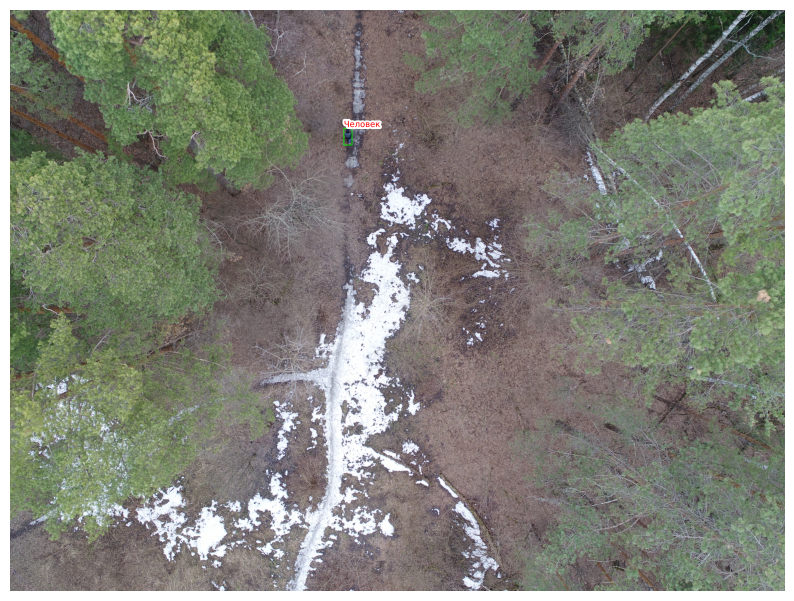

In [ ]:
class OpenImages(Dataset):
    def __init__(self, df, image_folder='/content/images/images/'):
        self.root = image_folder
#        self.root = [str(i) for i in self.root]
        self.df = df
        self.unique_images = df['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self, ix):
        image_id = self.unique_images[ix]
        image_path = f'{self.root}/{image_id}'
#        print(image_path)
        image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
#        print(image.shape)
#        print(image)
        h, w, _ = image.shape
        df = self.df.copy()
        df = df[df['ImageID'] == image_id]
        boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
        boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, boxes, classes, image_path
ds = OpenImages(df=DF_RAW)
im, bbs, clss, _ = ds[6]
show(im, bbs=bbs, texts=clss, sz=10)

In [ ]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [ ]:
class OpenDataset(torch.utils.data.Dataset):
    w, h = 224, 224
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = Glob(self.image_dir+'/*')
        self.files = [str(i) for i in self.files]
        self.df = df
        self.image_infos = df.ImageID.unique()
#        print(self.image_infos)
    def __getitem__(self, ix):
        # load images and masks
        image_id = self.image_infos[ix]
        img_path = self.df.iloc[ix]['Way']
#        print(img_path)
#        img = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w, self.h), resample=Image.BILINEAR))/255.
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values

        data[:,[0]] *= self.w
        data[:,[1]] *= self.h
        data[:,[2]] *= self.w
        data[:,[3]] *= self.h
        boxes = data.astype(np.uint32).tolist() # convert to absolute coordinates
        #torch FRCNN expects ground truths as a dictionary of tensors
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        img = preprocess_image(img)
#        print(img)
        return img, target
    def collate_fn(self, batch):
        return tuple(zip(*batch))
    def __len__(self):
        return len(self.image_infos)

In [ ]:
from sklearn.model_selection import train_test_split
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
#print(trn_ids, val_ids)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]
#print(trn_df, val_df)
#len(trn_df), len(val_df)
#----------------------------------------------------------------------------
# Удаляем картинки с очень маленькими коробками (т.к. после преобразований значения
# могут сравняться и получится нулевое значение)
df_little = trn_df[(trn_df['XMax'] - trn_df['XMin'] < 0.005) | (trn_df['YMax'] - trn_df['YMin'] < 0.005)]
lst = list(df_little.ImageID)
print(f'Картинки в которых есть очень маленькие коробки удаляем для train:\n{lst}')
trn_df = trn_df[trn_df.ImageID.isin(lst) == False]

df_l = val_df[(val_df['XMax'] - val_df['XMin'] < 0.007) | (val_df['YMax'] - val_df['YMin'] < 0.007)]
lst = list(df_l.ImageID)
print(f'Картинки в которых есть очень маленькие коробки удаляем для val:\n{lst}')
val_df = val_df[val_df.ImageID.isin(lst) == False]
#----------------------------------------------------------------------------
train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn, drop_last=True)

Картинки в которых есть очень маленькие коробки удаляем для train:
['121.jpg', '705.jpg', '705.jpg', '193.jpg', '629.jpg', '228.jpg', '228.jpg', '478.jpg', '321.jpg']

Картинки в которых есть очень маленькие коробки удаляем для val:
['1345.jpg', '1034.jpg', '1122.jpg', '1122.jpg', '1122.jpg', '1280.jpg', '1280.jpg', '148.jpg', '3.jpg', 
'1355.jpg', '1355.jpg']



---





---



In [ ]:
for i in train_ds:
  print(i)
  break

(
    tensor([[[0.5608, 0.5098, 0.5490,  ..., 0.3922, 0.4000, 0.4471],
         [0.5765, 0.5216, 0.4980,  ..., 0.4431, 0.3804, 0.4275],
         [0.4196, 0.6118, 0.5529,  ..., 0.4627, 0.3725, 0.4157],
         ...,
         [0.4039, 0.5333, 0.5765,  ..., 0.4353, 0.4118, 0.3529],
         [0.4118, 0.5059, 0.5412,  ..., 0.4196, 0.3961, 0.3725],
         [0.3725, 0.4314, 0.5059,  ..., 0.4000, 0.4039, 0.4078]],

        [[0.5529, 0.5255, 0.5569,  ..., 0.3804, 0.4196, 0.4471],
         [0.5725, 0.5137, 0.4902,  ..., 0.4157, 0.3922, 0.4314],
         [0.4118, 0.6039, 0.5412,  ..., 0.4392, 0.3804, 0.4353],
         ...,
         [0.3686, 0.4784, 0.5059,  ..., 0.5451, 0.5098, 0.4627],
         [0.3725, 0.4588, 0.4902,  ..., 0.5059, 0.4980, 0.4941],
         [0.3412, 0.3961, 0.4667,  ..., 0.5137, 0.5059, 0.4980]],

        [[0.5804, 0.5451, 0.5765,  ..., 0.4000, 0.4431, 0.4706],
         [0.5922, 0.5294, 0.5098,  ..., 0.4353, 0.4196, 0.4627],
         [0.4314, 0.6196, 0.5647,  ..., 0.4588, 0.4000, 0.4627],
         ...,
         [0.4157, 0.5529, 0.5725,  ..., 0.4471, 0.4431, 0.3647],
         [0.4157, 0.5176, 0.5451,  ..., 0.4353, 0.4118, 0.3882],
         [0.3647, 0.4235, 0.5098,  ..., 0.4000, 0.4078, 0.4196]]],
       device='cuda:0'),
    {'boxes': tensor([[ 73.,  96.,  76., 101.]]), 'labels': tensor([1])}
)

In [ ]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features #1024
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
# Defining training and validation functions for a single batch
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad() # this will disable gradient computation in the function below
def validate_batch(inputs, model):
    model.train() # to obtain the losses, model needs to be in train mode only. # #Note that here we are not defining the model's forward method
#and hence need to work per the way the model class is defined
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [ ]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
n_epochs = 3
log = Report(n_epochs)

In [ ]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
            [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss.item(),
                   trn_regr_loss=regr_loss.item(), trn_objectness_loss=loss_objectness.item(),
                   trn_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
          [losses[k] for k in ['loss_classifier','loss_box_reg','loss_objectness','loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss.item(),
                  val_regr_loss=regr_loss.item(), val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(), end='\r')
    if (epoch+1)%(n_epochs//3)==0: log.report_avgs(epoch+1)

In [ ]:
save_path = 'FASTER_R-CNN_1_epoch.pth'
torch.save(model.state_dict(), save_path)
!du -hsc {save_path} # size of the model on disk

159M	FASTER_R-CNN_1_epoch.pth
159M	total




---



---



**Выбираем картинку,обрабатываем,загружаем модель, используем**

In [ ]:
snow = trn_df[trn_df.ImageID == '100.jpg']
snow

,ImageID,LabelName,XMin,YMin,XMax,YMax,width,height,Way
3821,100.jpg,Человек,0.41375,0.958667,0.42750,0.981000,4000,3000,/content/images/images/100.jpg
3822,100.jpg,Человек,0.35900,0.786000,0.37425,0.804333,4000,3000,/content/images/images/100.jpg
3823,100.jpg,Человек,0.40250,0.813333,0.41625,0.827333,4000,3000,/content/images/images/100.jpg
3824,100.jpg,Человек,0.44800,0.820333,0.46200,0.838667,4000,3000,/content/images/images/100.jpg
3825,100.jpg,Человек,0.48700,0.817333,0.49825,0.829333,4000,3000,/content/images/images/100.jpg
3826,100.jpg,Человек,0.51625,0.796000,0.53100,0.816000,4000,3000,/content/images/images/100.jpg
3827,100.jpg,Человек,0.54150,0.818333,0.55325,0.832667,4000,3000,/content/images/images/100.jpg
3828,100.jpg,Человек,0.57625,0.834667,0.58975,0.851000,4000,3000,/content/images/images/100.jpg


In [ ]:
картинка = OpenDataset(snow)
картинка_загрузка = DataLoader(картинка, batch_size=1, collate_fn=train_ds.collate_fn, drop_last=True)

In [ ]:
for i in train_loader:
  print(i)

In [ ]:
load_path = '/content/FASTER_R-CNN_1_epoch.pth'
#model.load_state_dict(torch.load(load_path)) #  # строка при загрузке на GРU
model.load_state_dict(torch.load(load_path, map_location=torch.device('cpu'))) # строка при загрузке на СРU

<All keys matched successfully>

In [ ]:
from torchvision.ops import nms
def decode_output(output):
    'convert tensors to numpy arrays'
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]

    if len(ixs) == 1:
        bbs, confs, labels = [np.array([tensor]) for tensor in [bbs, confs, labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

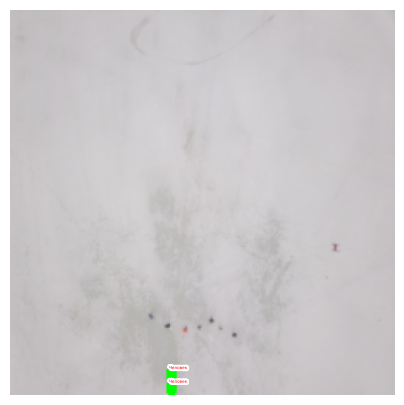

In [ ]:
model.eval()
for ix, (images, targets) in enumerate(картинка_загрузка):
#    if ix==3: break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
#        print(output['boxes'])
#        if output['labels'] == 0:continue
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0), bbs=bbs, texts=labels, sz=5)



---

